<a href="https://colab.research.google.com/github/sumanyurosha/tensorflow-specialization/blob/master/Practice/Emergency_Vehicle_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Solving Emergency Non-emergency Vehicle Classification Problem using Tensorflow. This problem was part of a AnalyticsVidya Janta Hackathon
You can find the problem [here](https://datahack.analyticsvidhya.com/contest/janatahack-computer-vision-hackathon/#ProblemStatement) 

# **1. Loading the Dataset**

In [45]:
# saving paths of dataset related files
train_csv = "/content/drive/My Drive/Resources/Datasets/janata-hackathon/train.csv"
base_dir = "/content/drive/My Drive/Resources/Datasets/janata-hackathon/images"


In [46]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import os
import time

In [47]:
df = pd.read_csv(train_csv)
df.head()

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0


# **2. Creating the Dataset**

In [48]:
def create_dataset(df):
    images = []
    labels = []

    for i in range(len(df)):
        image_path = os.path.join(base_dir, df["image_names"][i])
        image = keras.preprocessing.image.load_img(image_path)
        image = keras.preprocessing.image.img_to_array(image)
        images.append(image)
        labels.append(df["emergency_or_not"][i])

    return tf.data.Dataset.from_tensor_slices((tf.constant(images), tf.constant(labels)))

In [49]:
# splitting the Dataset into training and validation
split = 0.3
split_index = int(0.3 * len(df))

# loading the dataframe
df = pd.read_csv(train_csv)

# shuffling the dataframe
df = df.sample(frac=1).reset_index(drop=True)

valid_df = df.iloc[:split_index, :]
# dropping the index since we have to iterate it from 0 to n
train_df = df.iloc[split_index:, :].reset_index(drop=True)

print("Size of Training dataframe: {}".format(len(train_df)))
print("Size of Validation dataframe: {}".format(len(valid_df)))

Size of Training dataframe: 1153
Size of Validation dataframe: 493


In [50]:
valid_df.head()

,image_names,emergency_or_not
0,1723.jpg,0
1,2148.jpg,0
2,1259.jpg,0
3,459.jpg,1
4,671.jpg,1


In [51]:
train_dataset = create_dataset(train_df)
valid_dataset = create_dataset(valid_df)

# **3. Visualizing the Images in the Dataset**

In [52]:
 import matplotlib.pyplot as plt
 import matplotlib.image as mpimg

n_rows = 4
n_cols = 4

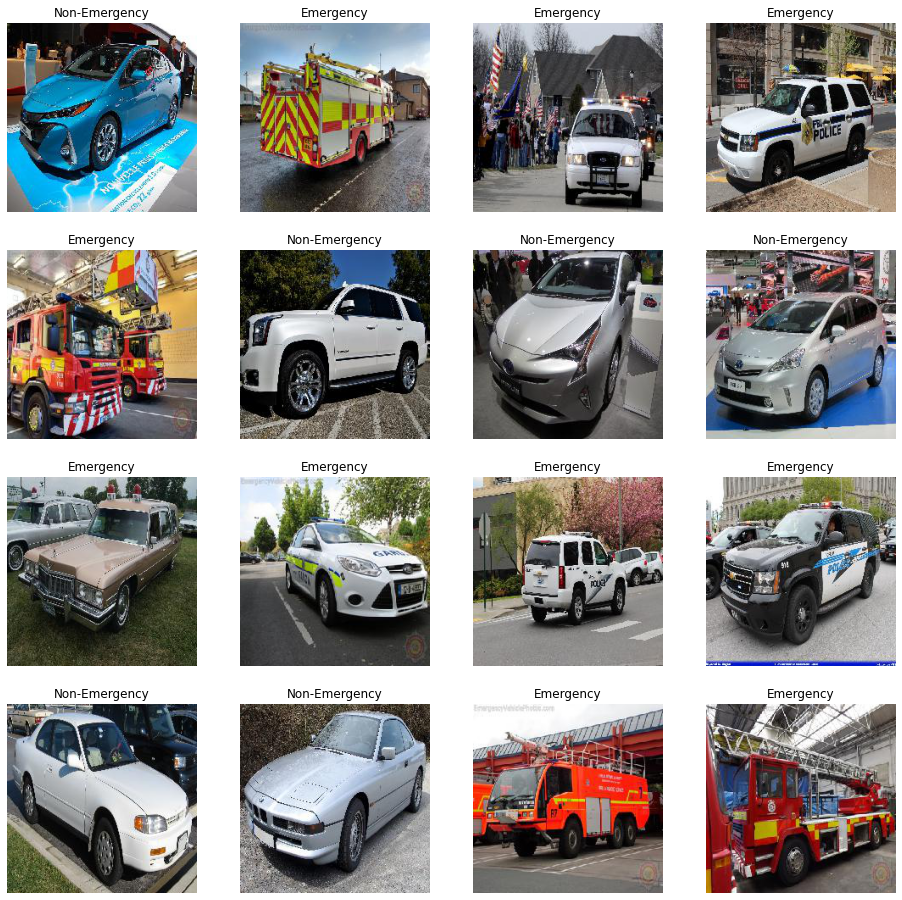

In [53]:
fig = plt.gcf()
fig.set_size_inches(n_rows*4, n_cols*4)

classes = ["Non-Emergency", "Emergency"]

for i, (image, label) in enumerate(train_dataset.take(16)):
    image = image.numpy()
    image = image/255.
    sp = plt.subplot(n_rows, n_cols, i+1)
    sp.axis("off")
    sp.title.set_text(classes[label])

    plt.imshow(image)

plt.show()
    

In [54]:
temp_dataset = create_dataset(train_df.iloc[:10, :])

# **4. Adding Data Augmentation**

In [55]:
data_augmentation = keras.models.Sequential([
    keras.layers.Input(shape=[224, 224, 3]),
    keras.layers.experimental.preprocessing.RandomHeight(0.2),
    keras.layers.experimental.preprocessing.RandomWidth(0.2),
    keras.layers.experimental.preprocessing.RandomZoom(0.2, 0.2),
    keras.layers.experimental.preprocessing.RandomRotation(0.4),
    keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    keras.layers.experimental.preprocessing.Rescaling(scale=1/255.),
    keras.layers.experimental.preprocessing.Resizing(224, 224)
]
)

data_augmentation.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_height_9 (RandomHeigh (None, None, 224, 3)      0         
_________________________________________________________________
random_width_9 (RandomWidth) (None, None, None, 3)     0         
_________________________________________________________________
random_zoom_9 (RandomZoom)   (None, None, None, 3)     0         
_________________________________________________________________
random_rotation_9 (RandomRot (None, None, None, 3)     0         
_________________________________________________________________
random_flip_9 (RandomFlip)   (None, None, None, 3)     0         
_________________________________________________________________
rescaling_9 (Rescaling)      (None, None, None, 3)     0         
_________________________________________________________________
resizing_1 (Resizing)        (None, 224, 224, 3)     

In [56]:
image, label = next(iter(temp_dataset))
image = image.numpy()
image = tf.expand_dims(image, 0)

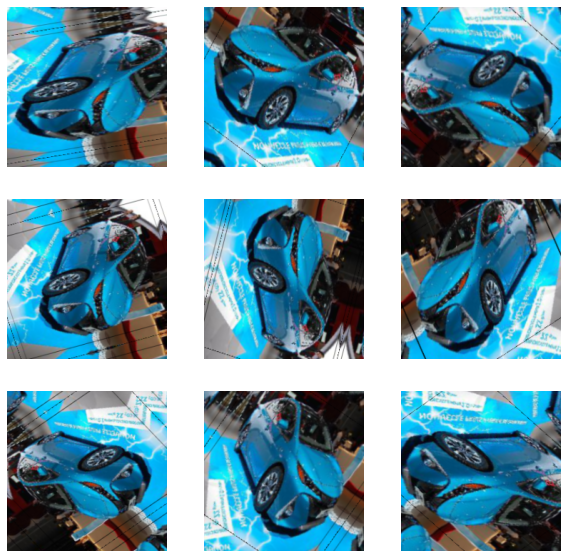

In [57]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [58]:
augmented_image.shape

TensorShape([1, 224, 224, 3])

# **4. Creating a Model from Scratch**

In [59]:
model = keras.models.Sequential([
    keras.layers.Input(shape=[224, 224, 3]),
    data_augmentation,
    keras.layers.Conv2D(16, (3,3), activation="relu",),
    keras.layers.MaxPool2D(2, 2),
    keras.layers.Conv2D(32, (3, 3), activation="relu"),
    keras.layers.MaxPool2D(2, 2),
    keras.layers.Conv2D(64, (3, 3), activation="relu"),
    keras.layers.MaxPool2D(2, 2),
    keras.layers.Conv2D(64, (3, 3), activation="relu"),
    keras.layers.MaxPool2D(2, 2),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_19 (Sequential)   (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 26, 26, 64)      

# 5. Training the Model

In [60]:
train_dataset = train_dataset.shuffle(500).batch(32).prefetch(1)
valid_dataset = valid_dataset.batch(32).prefetch(1)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])


history = model.fit(temp_dataset,
                    epochs=15,
                    validation_data=valid_dataset,
                    verbose=1)

Epoch 1/15


StagingError: ignored